In [1]:
import torch
import scanpy as sc
import anndata as ad
import scDiffusion as sd


/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
REF_PATH = 'reference/'
DATA_PATH = 'data/'
OUTPUT_PATH = 'outputs/'

# Load dataset

In [4]:
adata_ref = sc.read_h5ad(REF_PATH + 'adata_ref.h5ad')  # Reference 
adata_test = sc.read_h5ad(DATA_PATH + 'adata_new.h5ad')     # New Data

In [5]:
# 'ref_label' represents the reference cell identities. For New Data, set as "NewData" 
adata_ref.obs['ref_label']=adata_ref.obs['labels']
adata_test.obs['ref_label']= 'NewData'

In [6]:
# 'anno_batch' represent the batch information.
adata_ref.obs['anno_batch']= 'Reference'
adata_test.obs['anno_batch']= 'New'

In [7]:
# Combine Reference and New Data
adata = ad.concat([adata_ref, adata_test], merge='same')

# Preprocess

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:222: UserWarning: If you pass `n_top_genes`, all cutoffs are ignored.
  warnings.warn(msg, UserWarning)


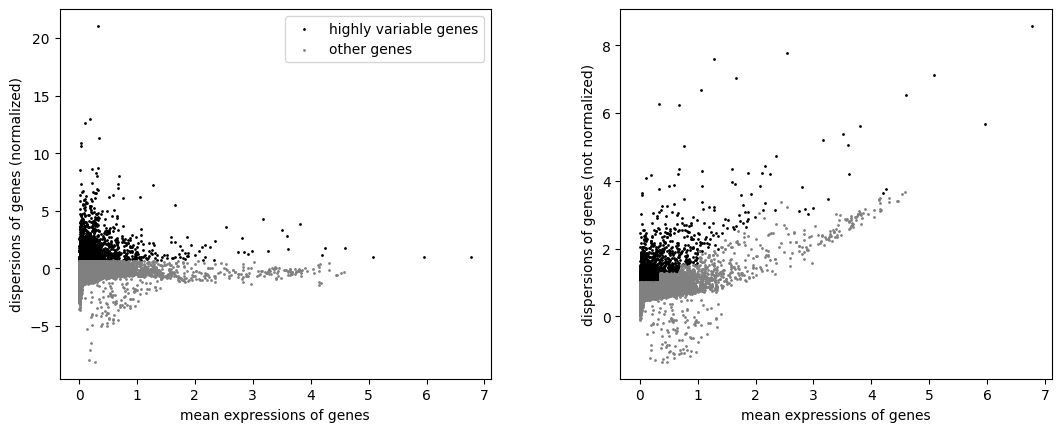

In [8]:
sc.pp.filter_genes(adata, min_cells=3)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes =2000, min_mean=0.0125, max_mean=9, min_disp=0.5)
sc.pl.highly_variable_genes(adata)


In [9]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

adata

View of AnnData object with n_obs × n_vars = 10552 × 2000
    obs: 'batch', 'labels', 'ref_label', 'anno_batch'
    var: 'gene_id', 'gene_symbols', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We use the normalized and log transformed data (NOT scaled data).

# Feature encoder

In [10]:
sd.encode_features(adata, 
                D_encode_list=[2000, 300, 50], 
                D_decode_list=[50, 300, 2000], 
                max_epoch=2000, 
                lr=1e-3, 
                device=device)


2024-10-17 11:25:51,767 - --------> Starting feature encoder ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/diffusion/feature_encoder.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_1 = torch.tensor(feature_matrix.to(device), dtype = feature_matrix_recover.dtype)
2024-10-17 11:26:01,410 - ------------------------> Epoch: 1/2000, Current loss: 6458898.0000
2024-10-17 11:26:02,253 - ------------------------> Epoch: 51/2000, Current loss: 2096800.6250
2024-10-17 11:26:03,092 - ------------------------> Epoch: 101/2000, Current loss: 1892013.5000
2024-10-17 11:26:03,925 - ------------------------> Epoch: 151/2000, Current loss: 1789319.5000
2024-10-17 11:26:04,765 - ------------------------> Epoch: 201/2000, Current loss: 1733937.8750
2024-10-17 11:26:05,587 - ------------------------> Epoch: 251/2000, Current loss: 1700813.

## view encoded embeddings

In [11]:
sc.pp.neighbors(adata, use_rep='X_fae', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

/projectnb/czproj/ycliu137/.conda/envs/graph_dif/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12040. The TBB threading layer is disabled.
  warnings.warn(problem)


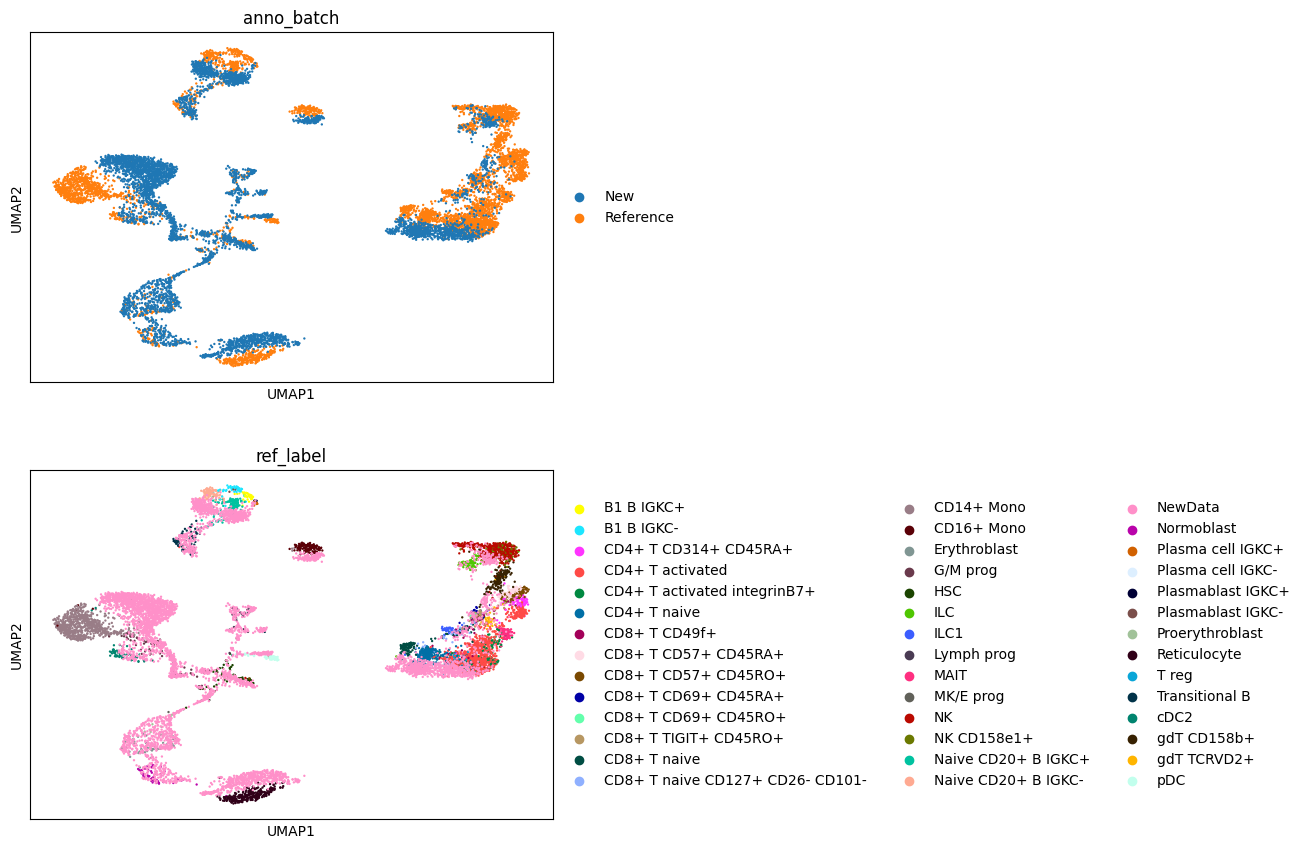

In [12]:
sc.pl.umap(adata, color=['anno_batch', 'ref_label'],ncols=1)

# Integration

In [13]:
# Due to high memory demands, consider using 'cpu' as a fallback if 'cuda' runs out of memory. 
# Although 'cpu' execution is slower, it can handle the task more efficiently in such cases and 
# typically completes in a few minutes.

sd.inte.evaluate_batch_isolation(adata, 
                            batch_key='anno_batch', 
                            use_rep = 'X_fae',
                            device=device)

In [14]:
sd.inte.build_integration_graph(adata, use_rep='X_fae', n_edges_per_node=50, device=device)

In [15]:
sd.inte.build_integration_loss_adj(adata, use_rep='X_fae', k=50, device=device)

In [16]:
sd.inte.integration_diffusion(adata, 
                              use_rep='X_fae',
                              max_epoch=2000, 
                              lr=1e-3, 
                              time_increment_diffusion=0.2,
                              device=device)


2024-10-17 11:27:23,457 - --------> Starting data integration ...
/projectnb/czproj/Algorithms/ycliu/scDiffusion/sc_integration/integration_DIF.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_now = torch.tensor(adjacency_list[ii].to(device), dtype = recon_adj_list[ii].dtype)
2024-10-17 11:27:23,736 - ------------------------> Epoch: 1/2000, Current loss: 2430749696.0000
2024-10-17 11:27:29,798 - ------------------------> Epoch: 51/2000, Current loss: 50768156.0000
2024-10-17 11:27:35,894 - ------------------------> Epoch: 101/2000, Current loss: 42125968.0000
2024-10-17 11:27:41,985 - ------------------------> Epoch: 151/2000, Current loss: 40434960.0000
2024-10-17 11:27:48,067 - ------------------------> Epoch: 201/2000, Current loss: 39701420.0000
2024-10-17 11:27:54,151 - ------------------------> Epoch: 251/2000, Curren

## View integrated embeddings

In [17]:
sc.pp.neighbors(adata, use_rep='X_dif', n_neighbors=50, n_pcs=50)
sc.tl.umap(adata)

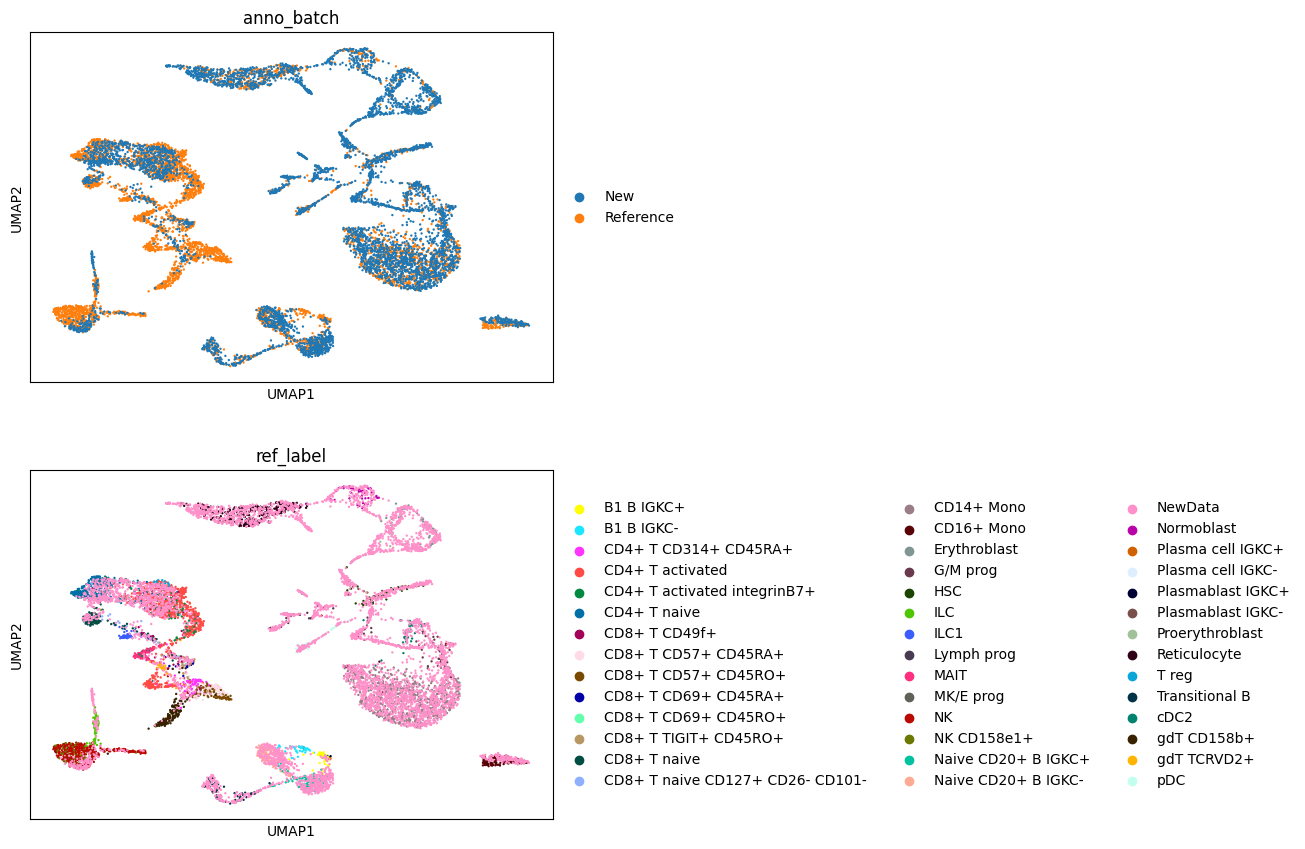

In [18]:
sc.pl.umap(adata, color=['anno_batch', 'ref_label'],ncols=1)

# Annotation

In [19]:
sd.anal.transfer_annotation(adata,   # Anndata object that combines Reference and New Data 
           use_rep='X_dif',        # the embeddings used to build the label transfer graph
           use_label='ref_label',     # For Reference, it should be cell identities to be transfer; For New Data, could be labeled as "New".
           batch_key='anno_batch',     # The key to distinguish Reference and New Data. 
           ref_batch='Reference',     # the batch label for Reference used in 'batch_key'
           data_batch='New',        # the batch label for New Data used in 'batch_key'
           n_edges_per_node=50,   # K-value in KNN graph or MNN graph
           use_mnn=False,       # if use MNN to build graph     
           device=device    # 'cpu' or 'cuda'
                    )

... storing 'batch_labels' as categorical
... storing 'transfered_labels' as categorical
... storing 'reference_alignment' as categorical


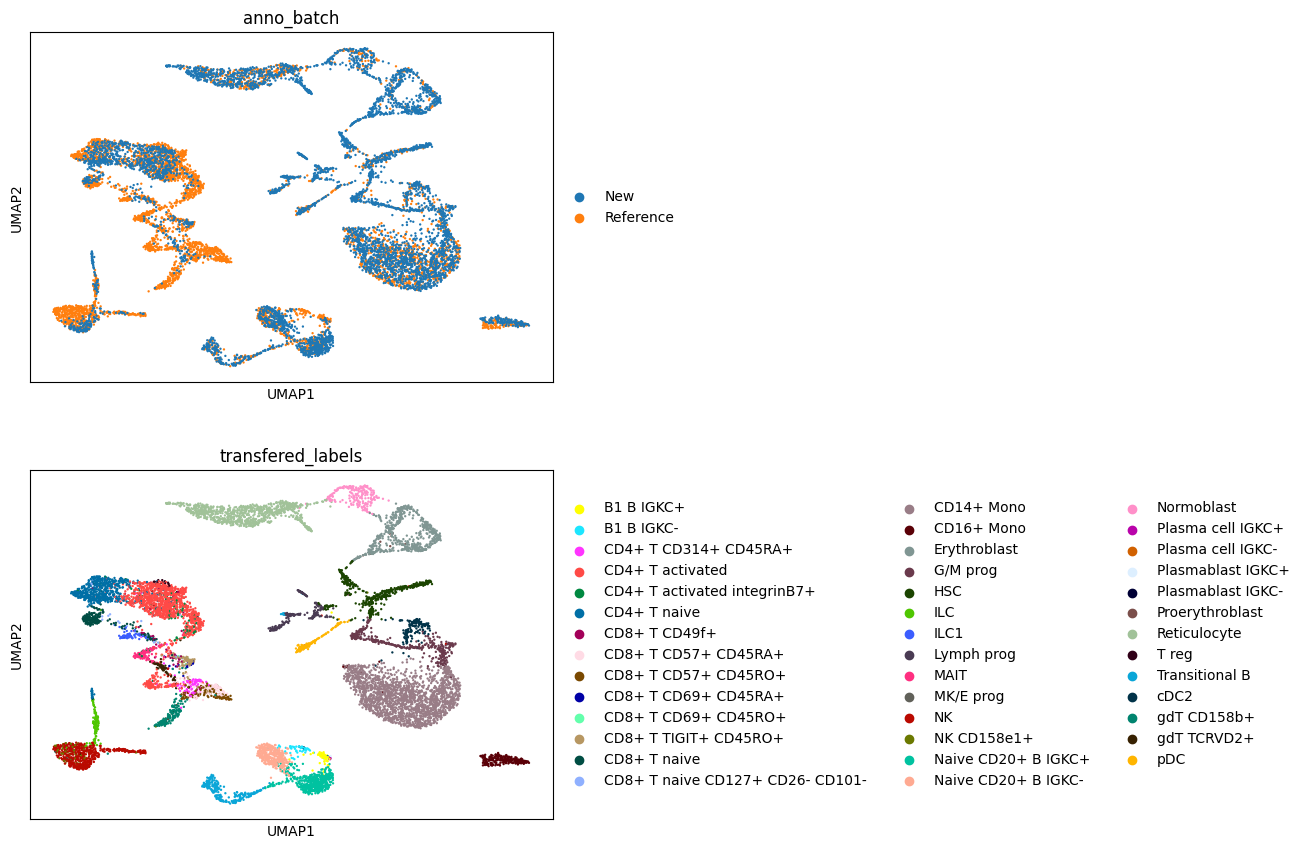

In [20]:
sc.pl.umap(adata, color=['anno_batch', 'transfered_labels'],ncols=1)

# Save data

In [21]:
adata.write(OUTPUT_PATH+'annotated_adata.h5ad')

In [22]:
adata = ad.read_h5ad(OUTPUT_PATH+'annotated_adata.h5ad')